In [18]:
import ctypes
import numpy             as np
import matplotlib.pyplot as plt
from   tqdm              import tqdm

### Importing C function

In [19]:
_mi = ctypes.CDLL('./libmi.so')

In [20]:
_mi.st_mi.argtypes = (ctypes.POINTER(ctypes.c_int), ctypes.POINTER(ctypes.c_int), ctypes.c_int)
_mi.st_mi.restype  = ctypes.c_float

### Defining wrapper for C function in python

In [21]:
def st_mi(x, y):
    global _mi
    n_bins = len(x)
    array_type = ctypes.c_int * n_bins
    MI = _mi.st_mi(array_type(*x), array_type(*y), ctypes.c_int(n_bins))
    return float(MI)

### Defining numpy function to compute MI

In [22]:
def py_mi(x,y):
    n = len(x)
    px  = np.unique(x, return_counts=True)[1] / n
    py  = np.unique(y, return_counts=True)[1] / n
    pxy = np.unique(np.array([x,y]).T, return_counts=True, axis=0)[1] / n
    
    Hx  = np.sum(-px*np.log2(px))
    Hy  = np.sum(-py*np.log2(py))
    Hxy = np.sum(-pxy*np.log2(pxy))
    
    return Hx + Hy - Hxy

### Method to generate dummy data

In [23]:
def multivariate_normal_bin(size, rho):
    cov  = [[1,rho],[rho,1]]
    x, y = np.random.multivariate_normal([0,0], cov, size).T
    return (x>0.5).astype(int), (y>0.5).astype(int)    

### Check if values match

In [24]:
rhos = np.linspace(0, 1, 10)

In [25]:
mi_c = []
for rho in rhos:
    x,y = multivariate_normal_bin(1000, rho)
    mi_c.append( st_mi(x,y) )

In [26]:
mi_py = []
for rho in rhos:
    x,y = multivariate_normal_bin(1000, rho)
    mi_py.append( py_mi(x,y) )

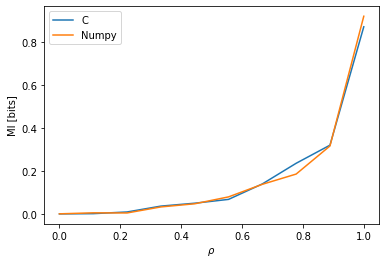

In [27]:
plt.plot(rhos, mi_c, label = 'C')
plt.plot(rhos, mi_py, label = 'Numpy')
plt.ylabel('MI [bits]')
plt.xlabel(r'$\rho$')
plt.legend()

### Comparing execution time as a funtion of the time-series length

In [28]:
T = np.arange(1000, 1000000, 100000, dtype = int)

In [30]:
t_c  = np.zeros([2,len(T)])
t_py = np.zeros([2,len(T)])
for i in tqdm(range(len(T)) ):
    x, y = multivariate_normal_bin(T[i], 0)
    t1 = %timeit -o py_mi(x,y)
    t2 = %timeit -o st_mi(x,y)
    t_py[0,i] = t1.average
    t_py[1,i] = t1.stdev
    t_c[0,i]  = t2.average
    t_c[1,i]  = t2.stdev

  0%|          | 0/10 [00:00<?, ?it/s]

652 µs ± 26.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


 10%|█         | 1/10 [00:10<01:34, 10.46s/it]

624 µs ± 15.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
82.2 ms ± 3.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


 20%|██        | 2/10 [00:22<01:28, 11.01s/it]

69.2 ms ± 1.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
168 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


 30%|███       | 3/10 [00:36<01:21, 11.71s/it]

149 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
282 ms ± 28.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


 40%|████      | 4/10 [00:40<00:56,  9.43s/it]

214 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
364 ms ± 17.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


 50%|█████     | 5/10 [00:45<00:40,  8.19s/it]

294 ms ± 25.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
508 ms ± 39.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


 60%|██████    | 6/10 [00:52<00:31,  7.80s/it]

345 ms ± 6.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
569 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


 70%|███████   | 7/10 [01:00<00:23,  7.88s/it]

437 ms ± 32.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
678 ms ± 32.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


 80%|████████  | 8/10 [01:09<00:16,  8.34s/it]

492 ms ± 9.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
814 ms ± 15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


 90%|█████████ | 9/10 [01:20<00:09,  9.12s/it]

542 ms ± 4.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
932 ms ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


100%|██████████| 10/10 [01:33<00:00,  9.34s/it]

635 ms ± 64.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<ipython-input-32-4a3836fad448>:2: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  plt.fill_between(T, t_c[0]-t_c[1], t_c[0]+t_c[1], 'b', alpha = .2)
<ipython-input-32-4a3836fad448>:4: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  plt.fill_between(T, t_py[0]-t_py[1], t_py[0]+t_py[1], 'r', alpha = .2)


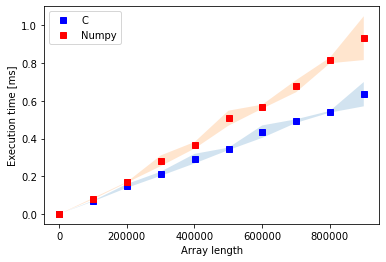

In [32]:
plt.plot(T, t_c[0], 'sb', label = 'C')
plt.fill_between(T, t_c[0]-t_c[1], t_c[0]+t_c[1], 'b', alpha = .2)
plt.plot(T, t_py[0], 'sr', label = 'Numpy')
plt.fill_between(T, t_py[0]-t_py[1], t_py[0]+t_py[1], 'r', alpha = .2)
plt.ylabel('Execution time [ms]')
plt.xlabel('Array length')
plt.legend()